In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
import pymc
import cronos 
import canon 
from magnus import ParEst

v_net = 483.86308564632014
t_res (for 1 m) = 0.0010333501662606168
n0 = 157050392.94379836 droplets/m³


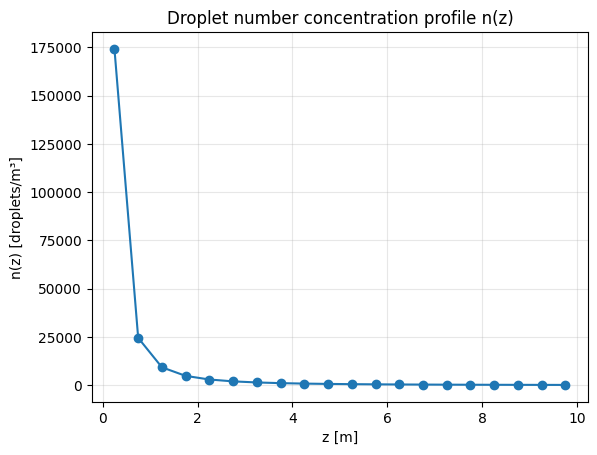

In [24]:
# --- geometry: near-/far-field radius profile -------------------------------

def z_transition(d0):
    """Transition from near-field to far-field, here 12 droplet diameters."""
    return 12 * d0
 
def radius_profile(z, d0, r0, theta_initial):
    """
    Spray radius r(z) with a near-field cone and a simple far-field linear growth.
    z can be scalar or array.
    """
    zt = z_transition(d0)
    r_transition = r0 + zt * np.tan(theta_initial)

    z = np.asarray(z)
    r_z = np.zeros_like(z, dtype=float)

    # near-field
    mask_near = z < zt
    r_z[mask_near] = r0 + z[mask_near] * np.tan(theta_initial)

    # far-field
    mask_far = ~mask_near
    r_z[mask_far] = r_transition + (z[mask_far] - zt) * 0.1   # far-field slope

    return r_z

# --- hydrodynamics ----------------------------------------------------------

def droplet_hydrodynamics(
    d0,                 # droplet diameter [m]
    rho_water=1000.0,   # density of water [kg/m³]
    rho_air=1.2,        # density of air [kg/m³]
    mu_gas=1.8e-5,      # gas viscosity [Pa s]
    Q_gas=5e-4,         # gas volumetric flowrate [m³/s]
    r_col=2.5,          # column radius [m]
    dz=1.0,             # layer thickness [m]
):
    g = 9.81
    # terminal velocity of a single droplet
    v_term = (2 * g * (rho_water - rho_air) * d0**2) / (9 * mu_gas)

    # gas superficial velocity
    A_col = np.pi * r_col**2
    u_gas = Q_gas / A_col

    v_net = v_term - u_gas
    t_res = dz / v_net
    return v_net, t_res

# --- number concentration at the nozzle -------------------------------------

#def droplet_number_concentration(Q_drop, r0, v_net, d0):
    """
    Compute n0 at z=0 assuming the spray cross-section has radius r0.
    """
    #A0 = np.pi * r0**2          # spray cross-section at the nozzle
    #V_spray_per_s = A0 * v_net  # spray volume flow through that area [m³/s]

    # Droplet volume fraction in that stream
    #phi_vol = Q_drop / V_spray_per_s

    # Volume of ONE droplet
    #V_drop = (4.0/3.0) * np.pi * (d0/2.0)**3

    # Number of droplets per m³ of spray
    #n0 = phi_vol / V_drop
    #return n0

# --- vertical profiles per layer -------------------------------------------

def layer_profiles(z_max, n_layers, d0, r0, theta_initial, Q_drop, Q_gas, r_col):
    z_edges = np.linspace(0.0, z_max, n_layers + 1)
    dz = z_edges[1] - z_edges[0]
    z_centers = z_edges[:-1] + 0.5 * dz

    # one vertical velocity for all layers
    v_net, _ = droplet_hydrodynamics(d0, Q_gas=Q_gas, r_col=r_col, dz=dz)

    # n0 at z = 0 uses r0 (not r_col!)
    #n0 = droplet_number_concentration(Q_drop, r0, v_net, d0)

    # radius and number concentration in each layer
    r_layers = radius_profile(z_centers, d0, r0, theta_initial)
    A_z = np.pi * r_layers**2
    V_drop = (4.0/3.0) * np.pi * (d0/2.0)**3
    n_vals = Q_drop / (v_net * A_z * V_drop)
    #n_vals   = n0 * (r0 / r_layers)**2

    return z_centers, r_layers, n_vals, dz

# --- parameters -------------------------------------------------------------

d0     = 2e-3     # droplet diameter [m]
r0     = d0 / 2   # as you requested: nozzle radius = droplet radius
Q_drop = 1e-3     # liquid volumetric flowrate [m³/s]
Q_gas  = 5e-4     # gas volumetric flowrate [m³/s]
r_col  = 2.5      # column radius [m]
theta_initial = np.deg2rad(15)  # spray cone half-angle

# compute profiles
z_centers, r_layers, n_layers, dz = layer_profiles(
    z_max=10.0,
    n_layers=20,
    d0=d0,
    r0=r0,
    theta_initial=theta_initial,
    Q_drop=Q_drop,
    Q_gas=Q_gas,
    r_col=r_col
)

# --- diagnostics ------------------------------------------------------------

v_net, t_res = droplet_hydrodynamics(d0, Q_gas=Q_gas, r_col=r_col, dz=dz)
#n0 = droplet_number_concentration(Q_drop, r0, v_net, d0)

print("v_net =", v_net)
print("t_res (for 1 m) =", t_res)
print("n0 =", n0, "droplets/m³")

# --- plot -------------------------------------------------------------------

plt.plot(z_centers, n_layers, marker="o")
plt.xlabel("z [m]")
plt.ylabel("n(z) [droplets/m³]")
plt.title("Droplet number concentration profile n(z)")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
IVPDAG = pymc.FFGraph()

#States 
X = pymc.FFVar(IVPDAG, "X") #biomass concentration
A = pymc.FFVar(IVPDAG, "A") #active photosynthesis  
B = pymc.FFVar(IVPDAG, "B") #occupied phoyosynthesis
C = pymc.FFVar(IVPDAG, "C") #damaged photosynthesis 
alpha = pymc.FFVar(IVPDAG, "alpha") #acclimation rate 
Ig = pymc.FFVar(IVPDAG, "G") #acclimation irradiance 
Xd = pymc.FFVar(IVPDAG, "Xd") #dormant biomass concentration

#Controls
v_net = pymc.FFVar(IVPDAG, "v_net") #net velocity 
I0 = pymc.FFVar(IVPDAG, "I0") #incident light intensity
D = pymc.FFVar(IVPDAG, "D") #dilution rate 

#initial concentrations 
X0 = pymc.FFVar(IVPDAG, "X0")
A0 = pymc.FFVar(IVPDAG, "A0")
B0 = pymc.FFVar(IVPDAG, "B0")
C0 = pymc.FFVar(IVPDAG, "C0")
alpha0 = pymc.FFVar(IVPDAG, "alpha0")
G0 = pymc.FFVar(IVPDAG, "G0")
Xd0 = pymc.FFVar(IVPDAG, "Xd0")

#parameters 
#n_z = pymc.FFVar(IVPDAG, "n_z") #droplet number concentration

#optical parameters
#beta_par = pymc.FFVar(IVPDAG, "beta") #extinction coefficient 
#sigma_par = pymc.FFVar(IVPDAG, "sigma") #scattering coefficient

#kinetic parameters
kr = pymc.FFVar(IVPDAG, "kr") #repair rate
kd = pymc.FFVar(IVPDAG, "kd") #damage rate
Res = pymc.FFVar(IVPDAG, "R") #Respiration rate 
tau = pymc.FFVar(IVPDAG, "tau") #turnover rate
xi = pymc.FFVar(IVPDAG, "xi") #NPQ rate 
n_h = pymc.FFVar(IVPDAG, "n_h") #HII component 
eta_P = pymc.FFVar(IVPDAG, "eta_P") #photoproduction 
eta_D = pymc.FFVar(IVPDAG, "eta_D") #thermal decay 
eta_qE = pymc.FFVar(IVPDAG, "eta_qE") #qE-quenching 
eta_I = pymc.FFVar(IVPDAG, "eta_I") #qI-quenching
nu = pymc.FFVar(IVPDAG, "nu") #stochiometry 
rho = pymc.FFVar(IVPDAG, "rho") #acclimation rate 
k_chi = pymc.FFVar(IVPDAG, "k_chi") #chi component 
N_0 = pymc.FFVar(IVPDAG, "N_0") #reference RCII
I_qE0 = pymc.FFVar(IVPDAG, "I_qE0") #NPQ interceept 
base0 = pymc.FFVar(IVPDAG, "base0") # base σ
e = pymc.FFVar(IVPDAG, "e") #NPQ slope 
PS2 = pymc.FFVar(IVPDAG, "PS2") #effective cross-section of photosystem II
theta0 = pymc.FFVar(IVPDAG, "theta0") #chi quota 

delta = pymc.FFVar(IVPDAG, "delta") #acclimation rate parameter
lamb = pymc.FFVar(IVPDAG, "lambda") #constant 

#constant
R_col = 2.5 #radius of droplet column

In [26]:
from scipy.special import spherical_jn, spherical_yn

def complex_refractive_index_droplet(theta_chl, X_gL, wavelength,
                                     a_chl_star,
                                     n_water=1.33,
                                     n_algae=1.39,
                                     rho_cell=1100.0): 
    """
    Computes complex refractive index of a water droplet containing microalgae.
    
    theta_chl : chlorophyll quota [g chl / g DW]
    X_gL      : biomass concentration in droplet [g DW / L]
    wavelength: wavelength [m]
    a_chl_star: chlorophyll-specific absorption [m^2/g chl]
    n_water   : refractive index of water
    n_algae   : refractive index of algal cytoplasm
    rho_cell  : cell density [kg/m^3]
    """

    # ---------- REAL PART (volume fraction mixing) ----------
    # Convert X from g/L → g/m3
    X_g_m3 = X_gL * 1000.0

    # Volume fraction of biomass in droplet
    f_vol = X_g_m3 / rho_cell
    f_vol = max(0.0, min(1.0, f_vol))  # clamp

    n_eff = f_vol * n_algae + (1 - f_vol) * n_water

    # ---------- IMAG PART (absorption from chlorophyll) ----------
    # Chlorophyll concentration in droplet [g/L → g/m3]
    C_chl_m3 = theta_chl * X_gL * 1000.0

    # absorption coefficient a(λ)
    a_lambda = a_chl_star * C_chl_m3   # [1/m]
    k_eff = a_lambda * wavelength / (4 * np.pi)
    n_new = n_eff + 1j * k_eff
    return n_new 

def mie_ab(m_rel, x, nmax):
    a = np.zeros(nmax, dtype=complex)
    b = np.zeros(nmax, dtype=complex)

    y = m_rel * x
    for n in range(1, nmax+1):
        jx   = spherical_jn(n, x)
        jx_p = spherical_jn(n, x, derivative=True)
        yx   = spherical_yn(n, x)
        yx_p = spherical_yn(n, x, derivative=True)
        hx   = jx + 1j*yx
        hx_p = jx_p + 1j*yx_p

        jy   = spherical_jn(n, y)
        jy_p = spherical_jn(n, y, derivative=True)

        a[n-1] = (m_rel*jy*jx_p - jx*jy_p) / (m_rel*jy*hx_p - hx*jy_p)
        b[n-1] = (jy*jx_p - m_rel*jx*jy_p) / (jy*hx_p - m_rel*hx*jy_p)

    return a, b

def mie_Qext(m_rel, r, wavelength):
    # r - droplet radius 
    x = 2*np.pi*r / wavelength
    nmax = int(np.round(x + 4*x**(1/3) + 2))
    a, b = mie_ab(m_rel, x, nmax)
    n = np.arange(1, nmax+1)
    Q_ext = (2/x**2) * np.sum((2*n+1)*np.real(a + b))
    Q_sca = (2/x**2) * np.sum((2*n+1)*(np.abs(a)**2 + np.abs(b)**2))
    return Q_ext, Q_sca

def mie_coeff(d, wavelength, m_rel, n_local):
    r = d0/2
    Q_ext, Q_sca = mie_Qext(m_rel, r, wavelength)
    C_ext = Q_ext * np.pi * r**2
    C_sca = Q_sca * np.pi * r**2
    beta_mie = n_local * C_ext
    sigma_mie = n_local * C_sca
    return beta_mie, sigma_mie

#Guess initial parameter values
if __name__ == "__main__":
    d0 = 2e-4
    wavelength = 550e-9
    theta_chi = 3.60
    X_gL = 3.0 
    a_chl_star = 20

    results = []
    for z, n_local in zip(z_centers, n_layers):
        n_eff = complex_refractive_index_droplet(theta_chi, X_gL, wavelength, a_chl_star)
        m_rel = n_eff / 1.33

        beta_mie, sigma_mie = mie_coeff(d0, wavelength, m_rel, n_local)
        results.append((z, n_local, beta_mie, sigma_mie))

    z_vals, n_vals, beta_vals, sigma_vals = map((np.array), zip(*results))
    
print("z (m):", z_vals[:5])
print("n(z) (1/m³):", n_vals[:5])
print("beta_mie:", beta_vals[:5])
print("sigma_mie:", sigma_vals[:5])

z (m): [0.25 0.75 1.25 1.75 2.25]
n(z) (1/m³): [174142.90486131  24520.2515549    9288.52357714   4845.5769878
   2968.02203511]
beta_mie: [0.01103832 0.00155425 0.00058877 0.00030714 0.00018813]
sigma_mie: [5.57869485e-03 7.85510045e-04 2.97559287e-04 1.55228807e-04
 9.50810442e-05]


In [ ]:
IVP = cronos.ODESLV()
IVP.set_dag(IVPDAG)
IVP.set_parameter([base0, kr, kd, Res, tau, xi, n_h, nu, eta_P, eta_D, eta_qE, eta_I, k_chi, e, PS2, rho, N_0, I_qE0, theta0, delta, lamb])
IVP.set_constant([I0, D, X0, A0, B0, C0, alpha0, G0, Xd0])
IVP.set_state([X, A, B, C, alpha, Ig, Xd])

time_grid = np.linspace(0, 0.1, 52).tolist() # 2 hours 
IVP.set_time(time_grid)
print(time_grid)

#mie profile
beta_profile = np.array(beta_vals)
sigma_profile = np.array(sigma_vals)
z_profile = np.array(z_vals)

def beta_sigma_at_z(z, X_tot):
    n_interp = np.interp(z, z_profile, n_layers)           # n(z)
    beta_interp = np.interp(z, z_profile, beta_profile)    # per m of n(z)=1
    sigma_interp = np.interp(z, z_profile, sigma_profile)
    return beta_interp * n_interp * X_tot, sigma_interp * n_interp * X_tot

# light model 
b = 0.15 
f = 1 - b
X_tot    = X + Xd
sqrt3 = np.sqrt(3.0)
K = 200 #number of spatial steps
#dx = R_col / K #discretize the droplet column height
z_grid = np.linspace(0, R_col, K)
dz = z_grid[1] - z_grid[0]

#Boundary conditions
F_plus = I0 
F_minus = 0.0 

for k in range(K):
    beta_k, sigma_k = beta_sigma_at_z(z_grid[k], X_tot)
    dF_plus = sqrt3 * (-beta_k*F_plus + sigma_k * (f*F_plus + b*F_minus))
    dF_minus = sqrt3 * ( beta_k*F_minus - sigma_k * (f*F_minus + b*F_plus))
    F_plus   = F_plus  + dF_plus  * dz
    F_minus  = F_minus + dF_minus * dz
    I = F_plus - F_minus

# growth model 
theta  = theta0 * Ig**k_chi
N      = N_0 * Ig**lamb
I_qE    = I_qE0 + e * Ig
mum_raw= (I * base0 * nu * 
            (A * eta_P) /
            (1 + eta_D + eta_qE*alpha + A*eta_P + C*eta_I)
            - Res) * theta

eps_mu  = 1e-12
mum_max = 5.0e-5    # [s^-1]  ≈ 0.18 h^-1
mum = mum_raw / (1.0 + ((mum_raw * mum_raw + eps_mu)**0.5) / mum_max) #bounded mum 

dIg = delta * (I - Ig) * mum
sigma_PS2 = base0 * eta_P / (N * (1 + eta_D + eta_qE*alpha + eta_P))
k_AB = I * sigma_PS2 * A                    # A → B (closure by light)
k_BA = B / tau                                  # B → A (reopening / relaxation)
k_BC = kd * I * sigma_PS2 * B              # B → C (photodamage)
k_CB = kr * C                                   # C → B (repair)

# 2. Conservative ODEs 
dA = -k_AB + k_BA 
dB =  k_AB - k_BA - k_BC + k_CB
dC =  k_BC - k_CB

Phi_f_A = 1.0 / (1 + eta_P + eta_D + eta_qE*alpha)
Phi_f_B = 1.0 / (1 + eta_D + eta_qE*alpha)
Phi_f_C = 1.0 / (1 + eta_I + eta_D + eta_qE*alpha)
NPQ_target = (I**n_h) / (I_qE**n_h + I**n_h)
dalpha =  -xi * (alpha - NPQ_target)

#biomass 
dX = (mum - D) * X   
dXd = Res * X - D * Xd       

IVP.set_differential([dX, dA, dB, dC, dalpha, dIg, dXd])    
IVP.set_initial([X0, A0, B0, C0, alpha0, G0, Xd0])
Y = [I, X, A, B, C, alpha, Ig, mum]
nY = len(Y)

# use function indices 0..nY-1 for every time point
F = [{j: Y[j] for j in range(nY)} for _ in time_grid]

IVP.set_function(F)
IVP.setup()
print(IVP.eqn_function)

[0.0, 0.00196078431372549, 0.00392156862745098, 0.0058823529411764705, 0.00784313725490196, 0.00980392156862745, 0.011764705882352941, 0.013725490196078431, 0.01568627450980392, 0.01764705882352941, 0.0196078431372549, 0.021568627450980392, 0.023529411764705882, 0.025490196078431372, 0.027450980392156862, 0.029411764705882353, 0.03137254901960784, 0.03333333333333333, 0.03529411764705882, 0.03725490196078431, 0.0392156862745098, 0.041176470588235294, 0.043137254901960784, 0.045098039215686274, 0.047058823529411764, 0.049019607843137254, 0.050980392156862744, 0.052941176470588235, 0.054901960784313725, 0.056862745098039215, 0.058823529411764705, 0.060784313725490195, 0.06274509803921569, 0.06470588235294117, 0.06666666666666667, 0.06862745098039216, 0.07058823529411765, 0.07254901960784313, 0.07450980392156863, 0.07647058823529412, 0.0784313725490196, 0.08039215686274509, 0.08235294117647059, 0.08431372549019608, 0.08627450980392157, 0.08823529411764705, 0.09019607843137255, 0.092156862

In [ ]:
IVP.options.DISPLEVEL = 1     # display numerical integration results
IVP.options.RESRECORD = 50    # record 50 points along time horizon

param_vals = [
    # --- optical (3) ---
    #beta_mie,      # 1  beta_par
    #sigma_mie,     # 2  sigma_par
    1.75,          # 3  base0

    # --- kinetic rates (7) ---
    5.50e-5,       # 4  kr
    6.41e-7,       # 5  kd
    1.78e-5,       # 6  Res
    5e-3,       # 7  tau
    5.95e-2,       # 8  xi
    2.26,          # 9  n_h
    4.0,           # 10 nu

    # --- photochemistry / quenching (6) ---
    1.14e1,        # 11 eta_P
    5.0e0,         # 12 eta_D
    1.98e1,        # 13 eta_qE
    7.87e1,        # 14 eta_I
    -1.89e-1,      # 15 k_chi
    4.48e-1,       # 16 e

    # --- acclimation / photoacclimation (6) ---
    1.38e-1,       # 17 rho
    1.71,          # 18 N_0
    8.13e2,        # 19 I_qE0
    3.60,          # 20 theta0
    1.38e-1,       # 21 delta
    1.22e-1        # 22 lamb
]

const_vals = [
    50,    # I0
    1.0e-7,   # D
    0.1,  # X0
    0.50,   # A0
    0.30,   # B0
    0.20,   # C0   (acclimation irradiance initial)
    0.0,   # alpha0   (incident light)
    100,    #G0   (dilution rate)
       0   # Xd0
]

# Run the IVP
IVP.solve_state(param_vals, const_vals)


In [ ]:
#simulated results
Pred_Exp = []
for rec in IVP.results_state: 
    Pred_Exp.append([rec.t] + rec.x) 
Pred_Exp = np.array(Pred_Exp) 

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# --- x ---
axes[0,0].plot(Pred_Exp[:,0], Pred_Exp[:,1], color="blue")
axes[0,0].set(xlabel="$t$ (s)")
axes[0,0].set(ylabel="$x$")

# --- a ---
axes[0,1].plot(Pred_Exp[:,0], Pred_Exp[:,2], color="blue")
axes[0,1].set(xlabel="$t$ (s)")
axes[0,1].set(ylabel="$a$")

# --- b ---
axes[0,2].plot(Pred_Exp[:,0], Pred_Exp[:,3], color="blue")
axes[0,2].set(xlabel="$t$ (s)")
axes[0,2].set(ylabel="$b$")

# --- c ---
axes[1,0].plot(Pred_Exp[:,0], Pred_Exp[:,4], color="blue")
axes[1,0].set(xlabel="$t$ (s)")
axes[1,0].set(ylabel="$c$")

# --- alpha ---
axes[1,1].plot(Pred_Exp[:,0], Pred_Exp[:,5], color="blue")
axes[1,1].set(xlabel="$t$ (s)")
axes[1,1].set(ylabel=r"$\alpha$")

# --- Ig ---
axes[1,2].plot(Pred_Exp[:,0], Pred_Exp[:,6], color="blue")
axes[1,2].set(xlabel="$t$ (s)")
axes[1,2].set(ylabel="$I_g$")

# Remove empty axes (there should be none)
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
fig.tight_layout()
plt.show()
